In [1]:
import torch
from tqdm.auto import tqdm

from point_e.diffusion.configs import DIFFUSION_CONFIGS, diffusion_from_config
from point_e.diffusion.sampler import PointCloudSampler
from point_e.models.download import load_checkpoint
from point_e.models.configs import MODEL_CONFIGS, model_from_config
from point_e.util.plotting import plot_point_cloud

import wandb
import matplotlib.pyplot as plt

In [2]:
from point_e.models.transformer import QKVMultiheadAttention

In [3]:
wandb.login(key='d4e1c3f09f3957dcfc5369909f0ecb3451224799')

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: axelcole. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/anguyenk/.netrc


True

In [4]:
# Initialize a new run
wandb.init(project='Point_e', name='Attention_maps')

In [5]:

def hook_fn(module, input, output, layer_name):
    """
    Hook function to extract and log attention weights and the layer name.
    """
    # Extract the attention weights from the output
    attention_avg = output[1].detach().cpu().numpy()  # output[1] contains attention weights

    # Create a heatmap using matplotlib
    plt.figure(figsize=(10, 8))
    plt.imshow(attention_avg, cmap='inferno', aspect='auto')
    plt.colorbar()
    plt.title(f"Attention Weights - Layer: {layer_name}")
    
    # Save the plot to a buffer
    frame_path = f"/home/anguyenk/Documents/point-e/point_e/examples/images/heatmap_{layer_name}_step_{step}.png"
    plt.savefig("/tmp/attention_heatmap.png")
    plt.close()

    # Initialize list for the layer if it doesn't exist
    if layer_name not in heatmap_frames_dict:
        heatmap_frames_dict[layer_name] = []

    # Append the saved frame path to the corresponding layer's list
    heatmap_frames_dict[layer_name].append(frame_path)  

    # Log the heatmap image to Weights and Biases
    wandb.log({f"{layer_name}": wandb.Image("/tmp/attention_heatmap.png")})

In [6]:
def register_attention_hooks(model):
    """
    Registers hooks for all QKVMultiheadAttention layers in the model.
    """
    for name, module in model.named_modules():
        if isinstance(module, QKVMultiheadAttention):
            # Register the hook and pass the layer name
            module.register_forward_hook(lambda mod, inp, out: hook_fn(mod, inp, out, name))


In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('creating base model...')
base_name = 'base40M-textvec'
base_model = model_from_config(MODEL_CONFIGS[base_name], device)
base_model.eval()
base_diffusion = diffusion_from_config(DIFFUSION_CONFIGS[base_name])

print('creating upsample model...')
upsampler_model = model_from_config(MODEL_CONFIGS['upsample'], device)
upsampler_model.eval()
upsampler_diffusion = diffusion_from_config(DIFFUSION_CONFIGS['upsample'])

print('downloading base checkpoint...')
base_model.load_state_dict(load_checkpoint(base_name, device))

print('downloading upsampler checkpoint...')
upsampler_model.load_state_dict(load_checkpoint('upsample', device))

creating base model...
creating upsample model...
downloading base checkpoint...
downloading upsampler checkpoint...


/home/anguyenk/Documents/point-e/point_e/models/download.py:78: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(path, map_location=device)


<All keys matched successfully>

In [8]:
register_attention_hooks(base_model)

In [9]:
register_attention_hooks(upsampler_model)

In [10]:
device

device(type='cuda')

In [11]:
base_model

CLIPImagePointDiffusionTransformer(
  (time_embed): MLP(
    (c_fc): Linear(in_features=512, out_features=2048, bias=True)
    (c_proj): Linear(in_features=2048, out_features=512, bias=True)
    (gelu): GELU(approximate='none')
  )
  (ln_pre): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (backbone): Transformer(
    (resblocks): ModuleList(
      (0-11): 12 x ResidualAttentionBlock(
        (attn): MultiheadAttention(
          (c_qkv): Linear(in_features=512, out_features=1536, bias=True)
          (c_proj): Linear(in_features=512, out_features=512, bias=True)
          (attention): QKVMultiheadAttention()
        )
        (ln_1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (c_fc): Linear(in_features=512, out_features=2048, bias=True)
          (c_proj): Linear(in_features=2048, out_features=512, bias=True)
          (gelu): GELU(approximate='none')
        )
        (ln_2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
     

In [12]:
upsampler_model

CLIPImageGridUpsamplePointDiffusionTransformer(
  (time_embed): MLP(
    (c_fc): Linear(in_features=512, out_features=2048, bias=True)
    (c_proj): Linear(in_features=2048, out_features=512, bias=True)
    (gelu): GELU(approximate='none')
  )
  (ln_pre): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (backbone): Transformer(
    (resblocks): ModuleList(
      (0-11): 12 x ResidualAttentionBlock(
        (attn): MultiheadAttention(
          (c_qkv): Linear(in_features=512, out_features=1536, bias=True)
          (c_proj): Linear(in_features=512, out_features=512, bias=True)
          (attention): QKVMultiheadAttention()
        )
        (ln_1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (c_fc): Linear(in_features=512, out_features=2048, bias=True)
          (c_proj): Linear(in_features=2048, out_features=512, bias=True)
          (gelu): GELU(approximate='none')
        )
        (ln_2): LayerNorm((512,), eps=1e-05, elementwise_affine

In [13]:
sampler = PointCloudSampler(
    device=device,
    models=[base_model, upsampler_model],
    diffusions=[base_diffusion, upsampler_diffusion],
    num_points=[1024, 4096 - 1024],
    aux_channels=['R', 'G', 'B'],
    guidance_scale=[3.0, 0.0],
    model_kwargs_key_filter=('texts', ''), # Do not condition the upsampler at all
)

In [14]:
sampler.num_stages

2

In [15]:
# Set a prompt to condition on.
prompt = 'a red motorcycle'

# Produce a sample from the model.
samples = None
for x in tqdm(sampler.sample_batch_progressive(batch_size=1, model_kwargs=dict(texts=[prompt]))):
    samples = x

0it [00:00, ?it/s]

wandb: Network error resolved after 0:00:21.174663, resuming normal operation.
wandb: Network error resolved after 0:00:21.345893, resuming normal operation.
wandb: Network error resolved after 0:00:21.204999, resuming normal operation.


: 

In [ ]:
wandb.finish()

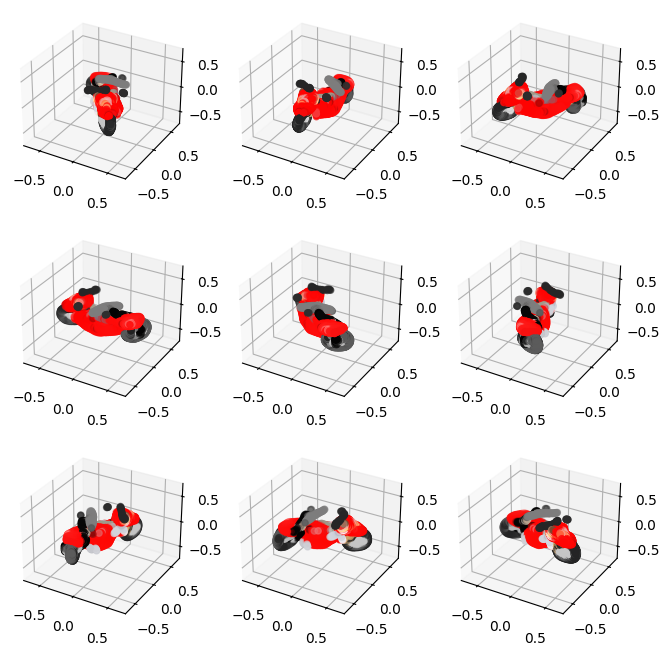

In [8]:
pc = sampler.output_to_point_clouds(samples)[0]
fig = plot_point_cloud(pc, grid_size=3, fixed_bounds=((-0.75, -0.75, -0.75),(0.75, 0.75, 0.75)))